In [1]:
# Import required libraries
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sns as sns
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

In [2]:
# Load data
data = pd.read_csv('ETH_USDT__data_1h.csv')
data.dropna(inplace=True)
data['date'] = pd.to_datetime(data['open_time'], unit='ms')
data.drop_duplicates(subset='date', keep='first', inplace=True)
df = data[['date', 'close', 'high', 'low', 'open']]
df.set_index('date', inplace=True)
df.head()

,close,high,low,open
date,,,,
2018-07-05 00:00:00,466.55,468.11,461.54,467.19
2018-07-05 01:00:00,473.69,476.60,465.44,466.33
2018-07-05 02:00:00,470.05,475.03,468.29,473.52
2018-07-05 03:00:00,470.57,473.02,469.40,470.16
2018-07-05 04:00:00,472.80,473.71,469.67,470.80


In [3]:
from ta.momentum import RSIIndicator, AwesomeOscillatorIndicator
from ta.trend import MACD, ADXIndicator
from ta.volatility import BollingerBands


def add_technical_indicators():
    """
    Add MACD, ADX, RSI, AO, BB to the dataframe
    :return:
    """
    # Create MACD using ta library
    df['macd'] = MACD(close=df['close'], window_slow=26, window_fast=12, window_sign=9).macd()

    # Create ADX using ta library
    df['adx'] = ADXIndicator(high=df['high'], low=df['low'], close=df['close'], window=14).adx()

    # Create upper and lower bollinger bands using ta library
    indicator_bb = BollingerBands(close=df['close'], window=20, window_dev=2)
    # df['upper_bb'] = indicator_bb.bollinger_hband()
    # df['lower_bb'] = indicator_bb.bollinger_lband()
    df['bb_perc'] = indicator_bb.bollinger_pband()  # Percentage band
    df['bb_width'] = indicator_bb.bollinger_wband()  # Width band

    # Create RSI using ta library
    df['rsi'] = RSIIndicator(close=df['close'], window=14).rsi()

    # Create Awesome Osciallator using ta library
    df['ao'] = AwesomeOscillatorIndicator(high=df['high'], low=df['low'], window1=5, window2=34).awesome_oscillator()

In [4]:
# Add technical indicators using the above function
add_technical_indicators()

C:\Users\nikhi\AppData\Local\Temp\ipykernel_13996\814528709.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['macd'] = MACD(close=df['close'], window_slow=26, window_fast=12, window_sign=9).macd()
c:\users\nikhi\pycharmprojects\crypto-trading-bot\venv\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
c:\users\nikhi\pycharmprojects\crypto-trading-bot\venv\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
C:\Users\nikhi\AppData\Local\Temp\ipykernel_13996\814528709.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

In [5]:
# Drop nan values
df = df.dropna()
# df.drop(labels=['high', 'low'], inplace=True, axis=1)
df.head()

,close,high,low,open,macd,adx,bb_perc,bb_width,rsi,ao
date,,,,,,,,,,
2018-07-06 09:00:00,457.00,461.24,455.65,459.24,-2.747612,18.615246,0.069426,3.921034,36.278783,-8.092088
2018-07-06 10:00:00,461.90,462.50,456.56,457.25,-2.574199,17.998913,0.354449,3.908913,45.318180,-9.225353
2018-07-06 11:00:00,463.22,463.96,460.74,461.90,-2.303699,17.056947,0.447432,3.631575,47.479633,-8.450353
2018-07-06 12:00:00,470.20,470.56,463.03,463.03,-1.508707,16.890225,0.862307,3.626582,57.129611,-5.970265
2018-07-06 13:00:00,467.49,470.29,466.51,470.20,-1.084839,16.735411,0.705173,3.597707,53.053804,-4.217618


In [6]:
p = 10
num_epochs = 100  # These settings are used while training the model
mini_batch_size = 32
dropout = 0.2

# Convert dataframe to numpy array
price_array = df.to_numpy()

In [7]:
# Scale the first 4 columns using min, max values
mini = np.min(price_array[:, :4])
maxi = np.max(price_array[:, :4])
print(mini, maxi)
price_array[:, :4] = (price_array[:, :4] - mini) / (maxi - mini)
price_array

81.79 515.47


array([[ 0.86517709,  0.87495388,  0.86206419, ...,  3.92103414,
        36.27878307, -8.09208824],
       [ 0.87647574,  0.87785925,  0.86416252, ...,  3.90891304,
        45.31818047, -9.22535294],
       [ 0.87951946,  0.88122579,  0.87380096, ...,  3.63157486,
        47.47963302, -8.45035294],
       ...,
       [ 0.11377052,  0.11404722,  0.11001199, ...,  4.8134797 ,
        38.24830084, -3.07079412],
       [ 0.11450839,  0.11577661,  0.11254842, ...,  5.05663718,
        39.94809616, -3.65452941],
       [ 0.11536156,  0.1162839 ,  0.11349382, ...,  5.19111427,
        41.93819515, -3.57417647]])

In [8]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Preprocess data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
# scaler = StandardScaler()
price_array[:, 4:] = scaler.fit_transform(price_array[:, 4:])
price_array

array([[0.86517709, 0.87495388, 0.86206419, ..., 0.12798977, 0.34602885,
        0.47810172],
       [0.87647574, 0.87785925, 0.86416252, ..., 0.12755375, 0.45087751,
        0.45932347],
       [0.87951946, 0.88122579, 0.87380096, ..., 0.11757734, 0.47594836,
        0.47216526],
       ...,
       [0.11377052, 0.11404722, 0.11001199, ..., 0.16009284, 0.36887343,
        0.56130476],
       [0.11450839, 0.11577661, 0.11254842, ..., 0.1688397 , 0.38858949,
        0.55163225],
       [0.11536156, 0.1162839 , 0.11349382, ..., 0.17367712, 0.4116728 ,
        0.5529637 ]])

In [9]:
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

def make_train_test_data(p_arr, test_size=0.2, shuffle=True):
    """
    This function creates training and testing data from the input array using p and q values provided above.
    :param p_arr:
    :param test_size:
    :param shuffle:
    :return:
    """
    # Make sequences of 100 previous values and take the next value as the target
    time_offset = p
    step = 1
    x_data = []
    y_data = []
    for index in range(time_offset, len(p_arr) - 1, step):
        x_data.append(p_arr[index - time_offset: index, :])
        y_data.append(p_arr[index, :4])
    x_data = np.array(x_data)
    y_data = np.array(y_data)

    # One hot encode the y_data
    # y_data = to_categorical(y_data)

    # y_data = y_data.reshape((y_data.shape[0], q, 1))

    # Split data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(x_data, y_data, test_size=test_size, shuffle=shuffle,
                                                        random_state=42)

    return X_train, Y_train, X_test, Y_test

In [10]:
# Split data into training and test sets using the above function
x_train, y_train, x_test, y_test = make_train_test_data(price_array, test_size=0.2, shuffle=False)
print('Shapes of x_train, x_test, y_train, y_test:', x_train.shape, x_test.shape, y_train.shape, y_test.shape)

Shapes of x_train, x_test, y_train, y_test: (3413, 10, 10) (854, 10, 10) (3413, 4) (854, 4)


In [11]:
from keras.layers import Bidirectional

# Create LSTM model
model = Sequential()
model.add(
    Bidirectional(LSTM(units=p, return_sequences=True)))
model.add(Dropout(dropout))
model.add(Bidirectional(LSTM(units=p * 2, return_sequences=True)))
model.add(Dropout(dropout))
model.add(Bidirectional(LSTM(units=p, return_sequences=False)))
model.add(Dense(units=4, activation='linear'))

# Build model with the input shape
model.build(input_shape=(None, x_train.shape[1], x_train.shape[2]))

# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()  # Print model summary

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 10, 20)           1680      
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 10, 20)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 10, 40)           6560      
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 10, 40)            0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 20)               4080      
 nal)                                                            
                                                        

In [12]:
# Train model
history = model.fit(x_train, y_train, epochs=num_epochs, batch_size=mini_batch_size, validation_split=0.1)

Epoch 1/100
96/96 [==============================] - 17s 55ms/step - loss: 0.0405 - val_loss: 0.0020
Epoch 2/100
96/96 [==============================] - 3s 34ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 3/100
96/96 [==============================] - 5s 49ms/step - loss: 0.0015 - val_loss: 0.0019
Epoch 4/100
96/96 [==============================] - 5s 49ms/step - loss: 0.0013 - val_loss: 0.0023
Epoch 5/100
96/96 [==============================] - 3s 33ms/step - loss: 0.0010 - val_loss: 0.0024
Epoch 6/100
96/96 [==============================] - 5s 54ms/step - loss: 9.2063e-04 - val_loss: 0.0028
Epoch 7/100
96/96 [==============================] - 5s 52ms/step - loss: 7.4878e-04 - val_loss: 0.0022
Epoch 8/100
96/96 [==============================] - 5s 53ms/step - loss: 7.0361e-04 - val_loss: 0.0019
Epoch 9/100
96/96 [==============================] - 5s 52ms/step - loss: 6.1956e-04 - val_loss: 0.0023
Epoch 10/100
96/96 [==============================] - 5s 52ms/step - loss: 6.1240e-

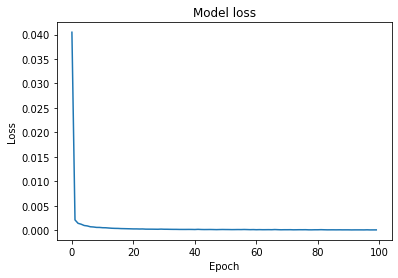

In [13]:
# Plot training loss vs number of epochs
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

C:\Users\nikhi\AppData\Local\Temp\ipykernel_13996\2734859159.py:3: RuntimeWarning: divide by zero encountered in true_divide
  erros = np.abs(predictions - y_test) / y_test * 100


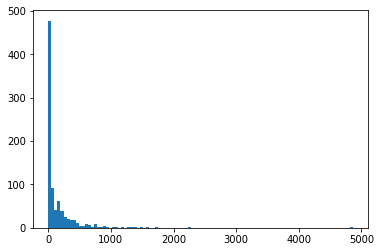

In [14]:
# Do a sample prediction
predictions = model.predict(x_test)
erros = np.abs(predictions - y_test) / y_test * 100

plt.hist(erros[:, 3], bins=100)
plt.show()

In [105]:
predictions[predictions[:, 1] < predictions[:, 2], :]

array([[0.7606014 , 0.75905514, 0.76129967, 0.75404286],
       [0.76027894, 0.75878096, 0.76085174, 0.75351185],
       [0.75985706, 0.7585706 , 0.76031095, 0.753022  ],
       [0.7597093 , 0.75873315, 0.7599979 , 0.7529244 ],
       [0.7592891 , 0.7584539 , 0.75934064, 0.7525375 ],
       [0.75842273, 0.7579037 , 0.7584422 , 0.7516822 ],
       [0.75726753, 0.75707084, 0.75729537, 0.7505922 ],
       [0.7574939 , 0.7572871 , 0.7574707 , 0.7509836 ],
       [0.7583889 , 0.757811  , 0.75817424, 0.7520059 ],
       [0.75855994, 0.7578643 , 0.7583996 , 0.75212276],
       [0.7591841 , 0.7583678 , 0.75902295, 0.75280017],
       [0.76129234, 0.7599833 , 0.76088136, 0.75494593],
       [0.7610968 , 0.7597609 , 0.760646  , 0.7545559 ],
       [0.76061404, 0.7593903 , 0.7602204 , 0.753948  ],
       [0.76058203, 0.7594044 , 0.76018065, 0.75393754],
       [0.75922424, 0.7584128 , 0.7589525 , 0.75252885],
       [0.7583907 , 0.75780547, 0.7582506 , 0.7517669 ],
       [0.7575837 , 0.7572113 ,

In [92]:
def inverse_transform(y):
        """
        This function is used to inverse transform the predicted values to the original scale.
        :param y: predicted values for a single time series sample
        :return:
        """
        # print(mini, maxi)
        return y * (maxi - mini) + mini

In [104]:
inverse_transform(predictions[0, :])

1700.48 4027.88


array([3470.7036, 3467.105 , 3472.3286, 3455.4392], dtype=float32)

In [25]:
# Convert predictions into trading signals
def convert_to_signal(cur_close, p_o, p_h, p_l, p_c):
    if p_h < p_l:
        return True

    if cur_close > p_o and cur_close > p_h and cur_close > p_l and cur_close > p_c:
        return True
    elif cur_close < p_o and cur_close < p_h and cur_close < p_l and cur_close < p_c:
        return False
    elif cur_close < p_o and cur_close < p_h and cur_close < p_c and cur_close > p_l:
        return True
    elif cur_close > p_o and cur_close > p_l and cur_close > p_c and cur_close < p_h:
        return False
    else:
        return True


1.0

In [47]:
x_test_n = x_test[:, :, :]
y_test_n = y_test[:, :]

In [48]:
import math

# Print the predicted and actual values
predicted = model.predict(x_test_n)

count = 0
balance = 500
stake = 100

total_profit = 0
trades = []
balance_history = []
diffs = []
for i in range(len(predicted)):
    cur_price = x_test_n[i, -1, 0]
    if cur_price == 0:
        continue
    p_diff = predicted[i][0] - cur_price
    a_diff = y_test_n[i][0][0] - cur_price
    diffs.append(abs(p_diff) * 100 / cur_price)
    sign = np.sign(p_diff * a_diff)
    if balance >= stake and 1 <= (abs(p_diff) * 100 / cur_price) <= 5:
        balance -= stake
        profit = stake * a_diff / cur_price
        if p_diff < 0:
            profit = -profit
        total_profit += profit
        balance += profit + stake
        stake = 0.2 * balance
        trades.append([cur_price, predicted[i][0], y_test_n[i][0][0], profit, abs(p_diff) * 100 / cur_price])
        balance_history.append(balance)

    if a_diff * p_diff > 0:
        count += 1

print('Accuracy:', count / len(predicted))
print('Balance:', balance)
print('Profit:', total_profit)
trades = np.array(trades)
trades

IndexError: invalid index to scalar variable.

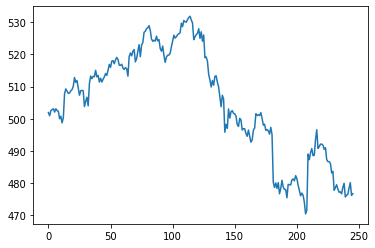

In [20]:
import matplotlib.pyplot as plt

# Plot the balance history
plt.plot(balance_history)
plt.show()

In [21]:
trades[trades[:, 3] < 0]

array([[  0.70210904,   0.71389544,   0.69510261,  -1.00180543,
          1.67871402],
       [  0.71020397,   0.72482139,   0.70304649,  -1.0140915 ,
          2.05819968],
       [  0.71026173,   0.718988  ,   0.70597879,  -0.60678882,
          1.22859935],
       [  0.70597879,   0.71464276,   0.70482808,  -0.16381851,
          1.22722858],
       [  0.69416072,   0.68513727,   0.71039502,  -2.34975066,
          1.29990718],
       [  0.71091483,   0.72293043,   0.69624887,  -2.06630789,
          1.69015984],
       [  0.7491503 ,   0.73591989,   0.75427739,  -0.69711603,
          1.7660549 ],
       [  0.75427739,   0.73775095,   0.75949778,  -0.70401212,
          2.19102944],
       [  0.73370239,   0.72632056,   0.74445861,  -1.50363235,
          1.00610606],
       [  0.71082598,   0.72660226,   0.69423625,  -2.3894524 ,
          2.21942925],
       [  0.69423625,   0.72128958,   0.67936591,  -2.18274937,
          3.8968477 ],
       [  0.68932686,   0.70668799,   0.688